In [1]:
!unzip /content/Dataset_Final.zip -d /content/Dataset_Final

Archive:  /content/Dataset_Final.zip
   creating: /content/Dataset_Final/Dataset_Final/
   creating: /content/Dataset_Final/Dataset_Final/Fashion/
   creating: /content/Dataset_Final/Dataset_Final/Fashion/test/
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_1.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_10.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_11.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_12.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_13.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_14.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_15.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_16.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_17.jpg  
  inflating: /content/Dataset_Final/Dataset_Final/Fashion/test/Defect_18.jpg  


In [2]:
!pip install timm faiss-cpu opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 86.1 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import torch
import timm
import faiss
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224
BATCH_SIZE = 16

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

In [ ]:
class UnsupervisedImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.images = [
            os.path.join(root, f)
            for f in os.listdir(root)
            if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img) 
        if self.transform:
            img = self.transform(img)
        return img

In [ ]:
TRAIN_DIR = "/content/Dataset_Final/Dataset_Final/Fashion/train"
VAL_DIR = "/content/Dataset_Final/Dataset_Final/Fashion/valid"

train_dataset = UnsupervisedImageDataset(TRAIN_DIR, transform)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Jumlah gambar train:", len(train_dataset))

Jumlah gambar train: 1093


In [ ]:
model = timm.create_model(
    "resnet18",
    pretrained=True,
    features_only=True,
    out_indices=[2] 
).to(DEVICE)

model.eval()

FeatureListNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=

In [ ]:
def extract_features(loader):
    feats_all = []

    with torch.no_grad():
        for imgs in tqdm(loader):
            imgs = imgs.to(DEVICE)

            feats = model(imgs)[0]        
            B, C, H, W = feats.shape

            feats = feats.permute(0, 2, 3, 1)
            feats = feats.reshape(-1, C)  

            feats_all.append(feats.cpu())

    feats_all = torch.cat(feats_all, dim=0)
    return feats_all.numpy()

In [ ]:
train_features = extract_features(train_loader)
print("Train feature shape:", train_features.shape)

100%|██████████| 69/69 [00:56<00:00,  1.23it/s]


Train feature shape: (856912, 128)


In [ ]:
DIM = train_features.shape[1]

faiss_index = faiss.IndexFlatL2(DIM)
faiss_index.add(train_features)

print("FAISS index size:", faiss_index.ntotal)

FAISS index size: 856912


In [ ]:
def patchcore_predict(img_path):
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError("Image not found")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        feats = model(img)[0]
        B, C, H, W = feats.shape

        feats = feats.permute(0, 2, 3, 1)
        feats = feats.reshape(-1, C).cpu().numpy()

    D, _ = faiss_index.search(feats, 1)
    score = float(D.mean())
    return score

val_dataset = UnsupervisedImageDataset(VAL_DIR, transform)

normal_scores = []
for img_path in val_dataset.images[:50]:
    score = patchcore_predict(img_path)
    normal_scores.append(score)

THRESHOLD = np.mean(normal_scores) + 1.5 * np.std(normal_scores)
print("Auto threshold:", THRESHOLD)

Auto threshold: 75.67749624588934


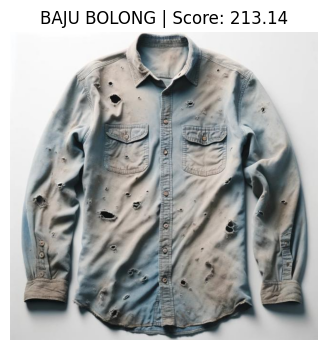

In [ ]:
img_path = "/content/Dataset_Final/Dataset_Final/Fashion/test/Defect_1.jpg"

score = patchcore_predict(img_path)
label = "BAJU BOLONG" if score > THRESHOLD else "BAJU NORMAL"

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.title(f"{label} | Score: {score:.2f}")
plt.axis("off")
plt.show()

In [ ]:
def get_label_from_name(filename):
    name = filename.lower()
    if "defect" in name:
        return 1  
    elif "normal" in name:
        return 0  
    else:
        raise ValueError(f"Label not found in filename: {filename}")

In [ ]:
TEST_DIR = "/content/Dataset_Final/Dataset_Final/Fashion/test"

y_true = []
y_scores = []

for fname in tqdm(os.listdir(TEST_DIR)):
    if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(TEST_DIR, fname)

    score = patchcore_predict(img_path)
    label = get_label_from_name(fname)

    y_scores.append(score)
    y_true.append(label)

y_true = np.array(y_true)
y_scores = np.array(y_scores)


100%|██████████| 218/218 [08:05<00:00,  2.23s/it]


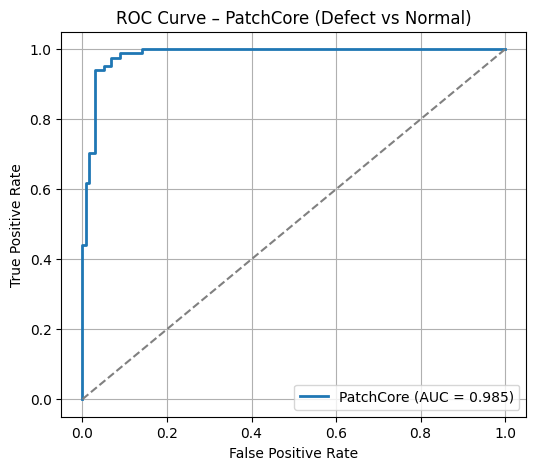

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2, label=f"PatchCore (AUC = {auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – PatchCore (Defect vs Normal)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def find_best_threshold(y_true, scores, n_steps=200):
    thresholds = np.linspace(scores.min(), scores.max(), n_steps)

    best_f1 = 0.0
    best_threshold = thresholds[0]

    for t in thresholds:
        y_pred = (scores >= t).astype(int)
        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold

In [ ]:
THRESHOLD = find_best_threshold(y_true, y_scores)

y_pred = (y_scores >= THRESHOLD).astype(int)

print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1-score:", f1_score(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)


Precision: 0.9518072289156626
Recall: 0.9404761904761905
F1-score: 0.9461077844311377
Accuracy: 0.9587155963302753


In [ ]:
os.makedirs("patchcore_assets", exist_ok=True)

np.save("patchcore_assets/train_features.npy", train_features)
faiss.write_index(faiss_index, "patchcore_assets/faiss_index.bin")
np.save("patchcore_assets/threshold.npy", np.array(THRESHOLD))

print("PatchCore assets saved successfully")

In [ ]:
!zip -r patchcore_assets.zip patchcore_assets